In [0]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import queue as queue

In [0]:
################################################################################
#For all the percentiles and numbers we used, we based off of the input analysis answer notebook from Canvas


#class representing state of a single mechanic
class Mechanic:
  def __init__(self, isBusy, Location, finishTime):
    self.isBusy = isBusy
    self.Location = Location
    self.finishTime = finishTime
    #utilization used to calculate metric later on
    self.utilization = 0
    
#class representing state of a van
class Van:
  def __init__(self, isBusy, finishTime):
    self.isBusy = isBusy
    self.finishTime = finishTime
    #utilization used to calculate metric later on
    self.utilization = 0

#in general, an event has a time and a location. We include this to ensure
#that call_event, mech_event, and van_event all have the same super class.
class Event:
  def __init__( self, time, Location):
    self.time = time
    self.Location = Location

#class representing call to dispatch center
class Call_Event(Event):
  def __init__(self,time, Location):
    self.time = time
    self.Location = Location
    self.p = np.random.uniform()
  def __lt__( self, other ):
    return self.time < other.time
    
#class representing a call for a mechanic
class Mech_Event(Event):
  def __init__(self, time, Location, p, mech):
    self.time = time
    self.Location = Location
    self.p = p
    self.mech_assign = mech
  def __lt__( self, other ):
    return self.time < other.time

#class representing a call for a van
class Van_Event(Event):
  def __init__(self, time, Location, van):
    self.time = time
    self.Location = Location
    self.van_assign = van
  def __lt__( self, other ):
    return self.time < other.time

#the two groups of call locations, important in discerning mech service times
Group1  = [2,3,9]
Group2  = [1,4,5,6,7,8,10]

#return the amount of time it will take mechanic to service at a provided location
def mech_service_time(Location):
    #ensure non-negative by taking max of normal distribution value with 0
    if Location in Group1:
        time = max(np.random.normal(22.15/60,5.34/60),0)
    elif Location in Group2:
        time = max(np.random.normal(16.13/60,2.89/60),0)
    
    return time

In [0]:
#create function for lambda parameter based on time of day
def lambda_(t):
    if t < 3:
        return 1.137
    elif t >= 3 and t < 22:
        return -0.067*t**2  + 1.581*t - 1.289
    else:
        return 1.137

#function for randomly generating the location of a call based on the
#probabilities of that call originating at a particular location
def location_func():  
  center = np.random.uniform()

  if center <= .0395085:
    loc = 1
  elif center <= .121597:
    loc = 2
  elif center <= .2295125:
    loc = 3
  elif center <= .3649305:
    loc = 4
  elif center <= .483317:
    loc = 5
  elif center <= .538322:
    loc = 6
  elif center <= .662153:
    loc = 7
  elif center <= .7200895:
    loc = 8
  elif center <= .857602:
    loc = 9
  else:
    loc = 10

  return loc

#set up 2d array for times
dc_ = [0,.75,.75,.583,.833,.9167,.4167,.583,.5,.583,.75]
bc1_ = [45/60,0,20/60,30/60,45/60,50/60,50/60,60/60,55/60,60/60,70/60]
bc2_ = [45/60,20/60,0,10/60,25/60,30/60,50/60,60/60,55/60,60/60,70/60]
bc3_ = [35/60,30/60,10/60,0,15/60,20/60,40/60,50/60,45/60,50/60,60/60]
bc4_ = [50/60,45/60,25/60,15/60,0,5/60,55/60,65/60,60/60,65/60,75/60]
bc5_ = [55/60,50/60,30/60,20/60,5/60,0,60/60,70/60,65/60,70/60,80/60]
bc6_ = [25/60,50/60,50/60,40/60,55/60,60/60,0,10/60,5/60,10/60,20/60]
bc7_ = [35/60,60/60,60/60,50/60,65/60,70/60,10/60,0,15/60,20/60,10/60]
bc8_ = [30/60,55/60,55/60,45/60,60/60,65/60,5/60,15/60,0,5/60,15/60]
bc9_ = [35/60,60/60,60/60,50/60,65/60,70/60,10/60,20/60,5/60,0,10/60]
bc10_ = [45/60,70/60,70/60,60/60,75/60,80/60,20/60,10/60,15/60,10/60,0]

times = [dc_, bc1_, bc2_, bc3_, bc4_, bc5_, bc6_, bc7_, bc8_, bc9_, bc10_]

In [0]:
niter = 1000
initialresponse_list = []
delivery_times_list = []
van_utilization = []
mech_utilization = []

for i in range(niter):
  
  #start our simulation clock (or "time of day") at 0
  simulation_clock = 0
  #list to represent the "key events" occurring throughout the day - this includes
  #a new call coming in, a mechanic finishing a repair, and a van finishing
  #servicing a customer and returning back to a location
  EventList = queue.PriorityQueue()
  #backlogs of events that still need to be serviced by a mechanic (for MechBacklog)
  #or by a van (for VanBackLog). Prioritized by earliest time of call
  MechBacklog = queue.PriorityQueue()
  VanBacklog = queue.PriorityQueue()
  #used to calculate metrics later on
  InitialResponseTime = []
  DeliveryTimes = 0
  #Counts how many deliveries of a copier were made in total
  DeliveryTimecounter = 0
  
  num_vans = 3
  num_mechanics = 8
  all_vans = []
  all_mechs = []
  #creating objects
  for i in range(num_vans):
    all_vans.append(Van(False,0))
  for i in range(num_mechanics):
    all_mechs.append(Mechanic(False,0,0))

  #create first arrival at time 0
  arrivaltime = np.random.exponential(1/lambda_(0))
  loc = location_func()
  first_event = Call_Event(arrivaltime, loc)

  #append the first event to the EventList
  EventList.put(first_event)

  while simulation_clock < 24:

    #get the event prioritized as the lowest time
    CurrentEvent = EventList.get()
    if(CurrentEvent.time > 24):
      break
    else:
      simulation_clock = CurrentEvent.time

    #if front of queue is same object type as CallEvent, then we are addressing
    #a call event this iteration and should make a new arrivaltime
    if isinstance(CurrentEvent, Call_Event):
      arrivaltime = np.random.exponential(1/lambda_(simulation_clock))
      loc = location_func()
      next_call = Call_Event(simulation_clock + arrivaltime, loc)
      EventList.put(next_call)

      #maintain times associated with free mechs that can service the call, where
      #the time represents how long the drive will take
      CurrentTravelTimes = []
      for i in range(len(all_mechs)):
          #if a mechanic is free, append its time to service this call to
          #the CurrentTravelTimes list
          if all_mechs[i].isBusy == False:
              CurrentTravelTimes.append((times[all_mechs[i].Location][CurrentEvent.Location],i))
      #if a mechanic is not currently free (and thus CurrentTravelTimes is empty), 
      #then add that call to our backlog for mechanic services
      if not CurrentTravelTimes:
        MechBacklog.put(CurrentEvent)

      #if we have an event and have mechs available to address that event
      if CurrentTravelTimes:
        #find closest mechanic available and assigns its 'index' to indexClosestMech
        indexClosestMech = min(CurrentTravelTimes)[1]
        #make this assigned mechanic busy
        all_mechs[indexClosestMech].isBusy = True
        #set mechanic location to the location of request
        all_mechs[indexClosestMech].Location = CurrentEvent.Location

        #  # Now calculate how long the mech will be busy for, ultimately to 
        #  # assign this mech's finish time (and make it busy until it has
        #  # spent appropriate time driving to event and servicing event)

        #use mech_service_time function to find mechTime
        mechTime = mech_service_time(CurrentEvent.Location)

        #if no van needed and mechanic does repair
        if CurrentEvent.p > .1795:
          time = np.random.beta(2.617986716241127, 7.461801823981)
          
        #if van is needed then mechanic does not do repair
        else:
          time = 0

        #calculate finish time as the current time + the optimal travel time +
        #the time needed to service + (potentially) the time needed to do
        #additional service in the case we do not call a van
        all_mechs[indexClosestMech].finishTime = (CurrentEvent.time + 
          min(CurrentTravelTimes)[0] + mechTime + time)
        
        #  # End calculation of mechanic finish time
        
        #newEvent represents an event for the mechanic finishing, with the 
        #associated time being that when the mechanic will finish processing
        newEvent = Mech_Event(all_mechs[indexClosestMech].finishTime, 
                        CurrentEvent.Location, CurrentEvent.p, indexClosestMech)

        #append the new event to EventList
        EventList.put(newEvent)
        
        #add mechanic repair time to the utilization
        all_mechs[indexClosestMech].utilization += (mechTime + time 
                                                + min(CurrentTravelTimes)[0])/24 

        #CASE 1 DEALING WITH RESPONSE TIME
        #calculate the amount of time it takes when customer places the call and
        #when mechanic reaches the customer location append intitial response 
        #time to array
        ResponseTime = min(CurrentTravelTimes)[0]
        InitialResponseTime.append(ResponseTime)

        #if a van is needed, we add the number to the DeliveryTimes counter
        if CurrentEvent.p <= .1795:
          DeliveryTimes += ResponseTime + mechTime
          DeliveryTimecounter += 1    

    #if front of queue is same object type as MechEvent, then we are addressing
    #a mech event (meaning a mechanic has just finished processing a call) and
    #should potentially reassign this mechanic to another call, and check 
    #whether or not this call also needs a van to service it
    elif isinstance(CurrentEvent, Mech_Event):
      #assign the mech that just finished to free, although it may be reassigned
      #later in this block and set back to busy
      all_mechs[CurrentEvent.mech_assign].isBusy = False

      #check whether or not a van is needed
      if CurrentEvent.p <= 0.1795:
        #check whether or not vans are available
        free_van_index = -1
        for i in range(len(all_vans)):
          #if a van is free, set the free_van_index to the index of this van
          #and set its status to busy
          if(all_vans[i].isBusy == False):
            free_van_index = i
            all_vans[i].isBusy = True
            break
        #if free_van_index is -1, then no free van available. Add this mech_event
        #to the van event backlog, meaning that when it will get serviced
        #when a van becomes free (and all other mechevents in the backlog have)
        #been addressed
        if free_van_index == -1:
          VanBacklog.put(CurrentEvent)
        #otherwise there is a free van, and we send that van to address this event
        else:

          # #calculations for setting the vans finishTime (when the van will)
          # #next be free

          #the swap at the clients business center
          swap_BC = np.random.triangular(20/60,30/60,60/60)
          #the swap at the dispatch center
          swap_DC = np.random.triangular(10/60,15/60,25/60)

          #update this vans finish time to be the current time plus
          #the travel time (to the location and back) plus the time it takes
          #to swap at the business center and at the dispatch center
          all_vans[free_van_index].finishTime = CurrentEvent.time + 2*times[0][CurrentEvent.Location] + swap_BC + swap_DC

          # #End calculations for setting the vans finishTime

          #calculation of metrics
          all_vans[free_van_index].utilization += (2*times[0][CurrentEvent.Location] + swap_BC + swap_DC)/24
          DeliveryTimes += times[0][CurrentEvent.Location] + swap_BC

          #newEvent represents an event for the van finishing, with the 
          #associated time being that when the van will return back to the
          #dispatch center
          newEvent = Van_Event(all_vans[free_van_index].finishTime, CurrentEvent.Location, free_van_index)
          #append the new event to EventList
          EventList.put(newEvent)
          

      #if there are any calls waiting, assign this now free mechanic to that call
      if MechBacklog.qsize() > 0:
        #print("mech backlog")
        #assign the call event object from the backlog to next_waiting_call
        next_waiting_call = MechBacklog.get()

        #maintain times associated with free mechs that can service the call, where
        #the time represents how long the drive will take
        CurrentTravelTimes = []
        for i in range(len(all_mechs)):
          #if a mechanic is free, append its time to service this call to
          #the CurrentTravelTimes list
          if all_mechs[i].isBusy == False:
              CurrentTravelTimes.append((times[(all_mechs[i].Location)][next_waiting_call.Location],i))
        #we assert that only one mechanic should be free, as if were more were 
        #free then they should have been assigned to one of the events in the 
        #backlog
        assert(len(CurrentTravelTimes)) == 1

        #find closest mechanic available and assigns its 'index' to indexClosestMech
        indexClosestMech = min(CurrentTravelTimes)[1]

        #the closestmech should have its status set to busy, its location set
        #to the location of the call, and the finish time set to the currenttime
        #plus travel time plus diagnosistime (mechtime) + onsite repair time (time)
        #similar to how these values are set above when a call is processed 
        all_mechs[indexClosestMech].isBusy = True
        all_mechs[indexClosestMech].Location = next_waiting_call.Location
        all_mechs[indexClosestMech].finishTime = (CurrentEvent.time + 
          min(CurrentTravelTimes)[0] + mechTime + time)
        
        #  # Now calculate how long the mech will be busy for, ultimately to 
        #  # assign this mech's finish time (and make it busy until it has
        #  # spent appropriate time driving to event and servicing event)
        #  # This is similar to above, but adapted to be taking an event
        #  # off of the backlog
        
        #use mech_service_time function to find mechTime
        mechTime = mech_service_time(next_waiting_call.Location)

        #if no van needed and mechanic does repair
        if next_waiting_call.p > .1795:
          time = np.random.beta(2.617986716241127, 7.461801823981)
          
        #if van is needed then mechanic does not do repair
        else:
          time = 0

        #calculate finish time as the current time + the optimal travel time +
        #the time needed to service + (potentially) the time needed to do
        #additional service in the case we do not call a van
        all_mechs[indexClosestMech].finishTime = (CurrentEvent.time + 
          min(CurrentTravelTimes)[0] + mechTime + time)
        
        #  # End finishTime calculation

        #newEvent represents an event for the mechanic finishing, with the 
        #associated time being that when the mechanic will finish processing
        newEvent = Mech_Event(all_mechs[indexClosestMech].finishTime, next_waiting_call.Location, next_waiting_call.p, indexClosestMech)

        #assign the mech that just got reassigned to a backlog event to busy
        all_mechs[CurrentEvent.mech_assign].isBusy = True

        #append the new event to EventList
        EventList.put(newEvent)

        #add mechanic repair time to the utilization
        all_mechs[indexClosestMech].utilization += (mechTime + time + min(CurrentTravelTimes)[0])/24 

        #RESPONSE TIME CASE 2
        #calculate the amount of time it takes when customer places the call and
        #when mechanic reaches the customer location append intitial response 
        #time to array
        ResponseTime = (min(CurrentTravelTimes)[0] + (CurrentEvent.time 
           - next_waiting_call.time))
        InitialResponseTime.append(ResponseTime)

         #if a van is needed, we add the number to the DeliveryTimes counter
        if next_waiting_call.p <= .1795:
          DeliveryTimes += ResponseTime + mechTime
          DeliveryTimecounter += 1  

    elif isinstance(CurrentEvent, Van_Event):
      #free up the van that completed the switch, although is may get reassigned
      #if there are events in the vanBacklog
      all_vans[CurrentEvent.van_assign].isBusy = False

      #if there are mechanics who called in for a van and are still waiting
      #to be addressed
      if VanBacklog.qsize()>0:
          #assign the next waiting mechanic call to be the earliest call for a 
          #van from the backlog
          next_waiting_mech = VanBacklog.get()

          #  #Start calculations for the vans finish time

          #the swap at the clients business center
          swap_BC = np.random.triangular(20/60,30/60,60/60)
          #the swap at the dispatch center
          swap_DC = np.random.triangular(10/60,15/60,25/60)

          DeliveryTimes += CurrentEvent.time - next_waiting_mech.time

          #update this vans finish time to be the current time plus
          #the travel time (to the location and back) plus the time it takes
          #to swap at the business center and at the dispatch center
          all_vans[CurrentEvent.van_assign].finishTime = CurrentEvent.time + 2*times[0][next_waiting_mech.Location] + swap_BC + swap_DC
          
          #  #End calculations for the vans finish time

          all_vans[CurrentEvent.van_assign].utilization = (2*times[0][next_waiting_mech.Location] + swap_BC + swap_DC)/24
          #create van event, representing the event when the van will be done
          #servicing this call from a mechanic
          newEvent = Van_Event(all_vans[CurrentEvent.van_assign].finishTime, next_waiting_mech.Location,CurrentEvent.van_assign)
          #set the van to busy, since it is servicing a call
          all_vans[CurrentEvent.van_assign].isBusy = True

          #append the new van event to EventList
          EventList.put(newEvent)

  #calculate metrics after the simulation block time has completed
  mech_util = 0
  van_util = 0
  #take the mean of all utilizations across mechanics
  for i in range(num_mechanics):
    mech_util += all_mechs[i].utilization/num_mechanics
  #take the mean of all utilizations across vans
  for i in range(num_vans):
    van_util += all_vans[i].utilization/num_vans
  
  #maintain the mean utilizations for this iteration
  mech_utilization.append(mech_util)
  van_utilization.append(van_util)
  #maintain innitial response time and delivery time for this iteration
  initialresponse_list.append(np.mean(InitialResponseTime))
  if(DeliveryTimecounter > 0):
    delivery_times_list.append(DeliveryTimes/DeliveryTimecounter) 

The Confidence Interval for initial response times is [ 0.9354863954806861 ,  0.999029263287004 ]


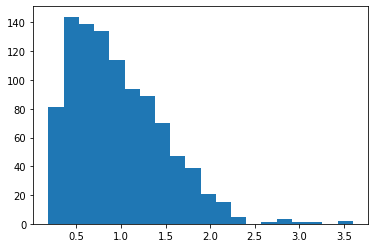

In [43]:
#histogram and confidence interval for initial response time

n = len(initialresponse_list)
mean = np.mean(initialresponse_list)
std = np.std(initialresponse_list)

UB = mean + 1.96*std/(n**.5)
LB = mean - 1.96*std/(n**.5)

print("The Confidence Interval for initial response times is [",LB,", ",UB,"]")

plt.hist(initialresponse_list,bins=20)
plt.show()

The Confidence Interval for the time taken to replace the copiers is [ 2.5467328266589493 ,  2.624982098932659 ]


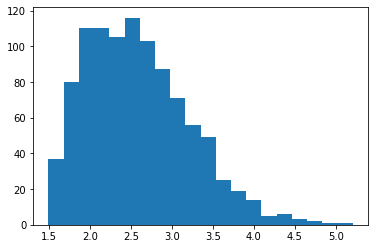

In [44]:
n = len(delivery_times_list)
mean = np.mean(delivery_times_list)
std = np.std(delivery_times_list)

UB = mean + 1.96*std/(n**.5)
LB = mean - 1.96*std/(n**.5)

print("The Confidence Interval for the time taken to replace the copiers is [",LB,", ",UB,"]")

plt.hist(delivery_times_list,bins=20)
plt.show()

The Confidence Interval for mech utilization is [ 0.6137155329581269 ,  0.6263599315905094 ]


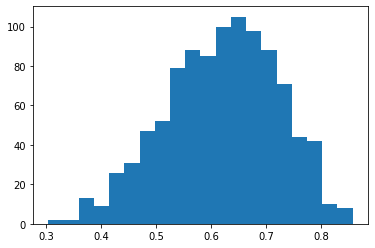

In [45]:
#histogram and confidence interval for mech util

n = len(mech_utilization)
mean = np.mean(mech_utilization)
std = np.std(mech_utilization)

UB = mean + 1.96*std/(n**.5)
LB = mean - 1.96*std/(n**.5)

print("The Confidence Interval for mech utilization is [",LB,", ",UB,"]")

plt.hist(mech_utilization,bins=20)
plt.show()

The Confidence Interval for van utilization is [ 0.15114955727864476 ,  0.16172731181994054 ]


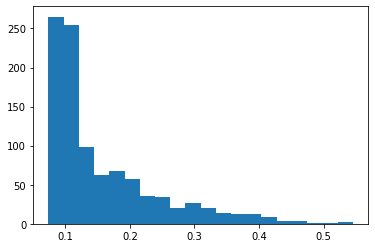

[0.08540382247224647, 0.0979433229884671, 0.08546103707226013, 0.1751840947499515, 0.08738582182435002, 0.24190526806152374, 0.09364918123169065, 0.21407520038778693, 0.1013702064093681, 0.15579304362650262, 0.10355681479219991, 0.09589862254065726, 0.09993272910291012, 0.26163589229589274, 0.09701327973439722, 0.10154293717578963, 0.17093867896344506, 0.3777130815460656, 0.1988298541814002, 0.09745847084094851, 0.10709790892798612, 0.13116627027818495, 0.18698069335962594, 0.17456412430379198, 0.07989387827591057, 0.08598125415022703, 0.10440531707632193, 0.5453364268088301, 0.13807605390878597, 0.08482096294244784, 0.10083136567997938, 0.09930977383511913, 0.09542229206413705, 0.12146939706425058, 0.08908848395870593, 0.08448866563516026, 0.1026514664019272, 0.09615135009295986, 0.43447434958342707, 0.09745485462218967, 0.2290265156203044, 0.10054471726594957, 0.09730342302615236, 0.4045643197509873, 0.1022368665519128, 0.3548411802725873, 0.09917587197444422, 0.09551889624989156, 0.

In [46]:
#histogram and confidence interval for van util

n = len(van_utilization)
mean = np.mean(van_utilization)
std = np.std(van_utilization)

UB = mean + 1.96*std/(n**.5)
LB = mean - 1.96*std/(n**.5)

print("The Confidence Interval for van utilization is [",LB,", ",UB,"]")

plt.hist(van_utilization,bins=20)
plt.show()
print(van_utilization)